In [1]:
# import the required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import random

Dataset Link - https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation

In [2]:
# read the file containing MRI image path and labels
brain_df = pd.read_csv('Brain_MRI/data_mask.csv')

In [3]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [4]:
brain_df.head()

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [5]:
# 0 - No Tumor (2556 Images)
# 1 - Tumor (1373 Images)
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

## DATA VISUALISATION

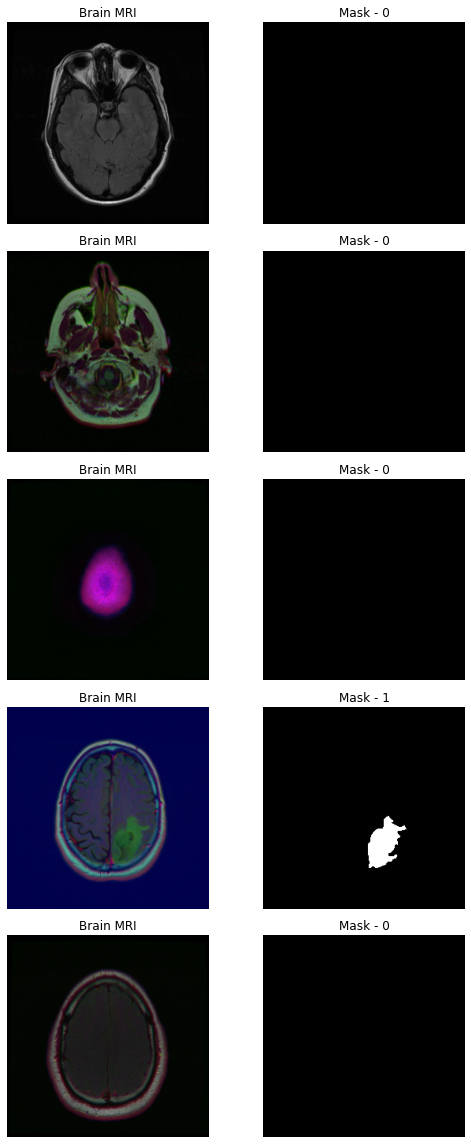

In [6]:
# Visualize the images (MRI and Mask) in the dataset separately

fig, axs = plt.subplots(5,2, figsize=(8,16))

count = 0
for x in range(5):
    i = random.randint(0, len(brain_df)) # select a random index
    axs[count][0].axis('off')
    axs[count][0].title.set_text("Brain MRI") # set title
    axs[count][0].imshow(cv2.imread('Brain_MRI/' + brain_df.image_path[i])) # show MRI 
    axs[count][1].axis('off')
    axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
    axs[count][1].imshow(cv2.imread('Brain_MRI/' + brain_df.mask_path[i])) # Show corresponding mask
    count += 1

fig.tight_layout()

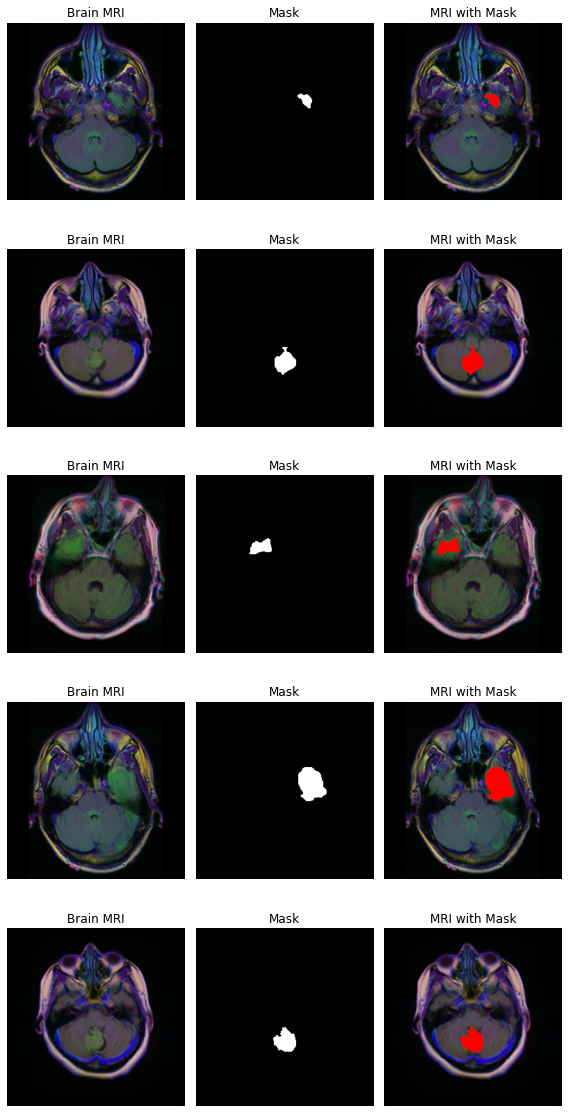

In [7]:
count = 0
fig, axs = plt.subplots(5, 3, figsize = (8, 16))
for i in range(len(brain_df)):
    if brain_df['mask'][i] ==1 and count <5:
        img = io.imread('Brain_MRI/' + brain_df.image_path[i])
        axs[count][0].axis('off')
        axs[count][0].title.set_text('Brain MRI')
        axs[count][0].imshow(img)

        mask = io.imread('Brain_MRI/' + brain_df.mask_path[i])
        axs[count][1].axis('off')
        axs[count][1].title.set_text('Mask')
        axs[count][1].imshow(mask, cmap = 'gray')

    
        img[mask == 255] = (255, 0, 0)
        axs[count][2].axis('off')
        axs[count][2].title.set_text('MRI with Mask')
        axs[count][2].imshow(img)
        count+=1

fig.tight_layout()

In [8]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [9]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [10]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [11]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [12]:
# create a image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

In [13]:
train_generator=datagen.flow_from_dataframe(dataframe=train,
                                            directory= './Brain_MRI/',
                                            x_col='image_path',
                                            y_col='mask',
                                            subset="training",
                                            batch_size=16,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(128,128))


valid_generator=datagen.flow_from_dataframe(dataframe=train,
                                            directory= './Brain_MRI/',
                                            x_col='image_path',
                                            y_col='mask',
                                            subset="validation",
                                            batch_size=16,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(128,128))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [14]:
# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(dataframe=test,
                                                directory= './Brain_MRI/',
                                                x_col='image_path',
                                                y_col='mask',
                                                batch_size=16,
                                                class_mode='categorical',
                                                target_size=(128,128))

Found 590 validated image filenames belonging to 2 classes.


In [15]:
model = tf.keras.models.Sequential([
    layers.InputLayer(input_shape=(128, 128, 3)),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax'),
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0

In [17]:
# compile the model
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [18]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier_weights.h5", verbose=1, save_best_only=True)

In [19]:
history = model.fit(train_generator,
                    epochs = 100, 
                    validation_data= valid_generator,
                    callbacks=[checkpointer, earlystopping])

Epoch 1/100
178/178 [==============================] - 11s 39ms/step - loss: 0.6021 - accuracy: 0.6707 - val_loss: 0.5167 - val_accuracy: 0.7360

Epoch 00001: val_loss improved from inf to 0.51667, saving model to classifier_weights.h5
Epoch 2/100
178/178 [==============================] - 5s 31ms/step - loss: 0.4814 - accuracy: 0.7478 - val_loss: 0.4495 - val_accuracy: 0.7720

Epoch 00002: val_loss improved from 0.51667 to 0.44952, saving model to classifier_weights.h5
Epoch 3/100
178/178 [==============================] - 5s 29ms/step - loss: 0.4434 - accuracy: 0.7693 - val_loss: 0.4127 - val_accuracy: 0.7700

Epoch 00003: val_loss improved from 0.44952 to 0.41269, saving model to classifier_weights.h5
Epoch 4/100
178/178 [==============================] - 5s 30ms/step - loss: 0.4267 - accuracy: 0.7809 - val_loss: 0.4009 - val_accuracy: 0.7860

Epoch 00004: val_loss improved from 0.41269 to 0.40090, saving model to classifier_weights.h5
Epoch 5/100
178/178 [==========================


Epoch 00038: val_loss did not improve from 0.08700
Epoch 39/100
178/178 [==============================] - 7s 37ms/step - loss: 0.0654 - accuracy: 0.9757 - val_loss: 0.0738 - val_accuracy: 0.9800

Epoch 00039: val_loss improved from 0.08700 to 0.07376, saving model to classifier_weights.h5
Epoch 40/100
178/178 [==============================] - 6s 36ms/step - loss: 0.0769 - accuracy: 0.9732 - val_loss: 0.1241 - val_accuracy: 0.9600

Epoch 00040: val_loss did not improve from 0.07376
Epoch 41/100
178/178 [==============================] - 6s 34ms/step - loss: 0.0638 - accuracy: 0.9771 - val_loss: 0.0857 - val_accuracy: 0.9840

Epoch 00041: val_loss did not improve from 0.07376
Epoch 42/100
178/178 [==============================] - 6s 33ms/step - loss: 0.0545 - accuracy: 0.9799 - val_loss: 0.1071 - val_accuracy: 0.9640

Epoch 00042: val_loss did not improve from 0.07376
Epoch 43/100
178/178 [==============================] - 6s 33ms/step - loss: 0.0654 - accuracy: 0.9789 - val_loss: 0.

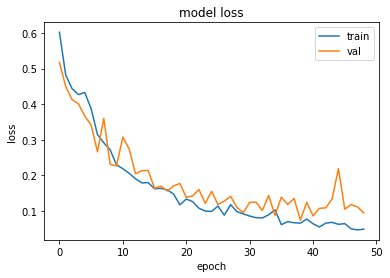

In [22]:
# The is how training loss and validation loss varied during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

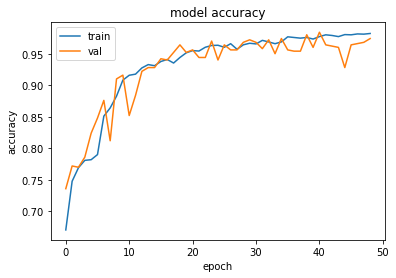

In [23]:
# The is how training accuracy and validation accuracy varied during training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("classifier_model.json","w") as json_file:
    json_file.write(model_json)

In [25]:
# Load pretrained model 
with open('classifier_model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('classifier_weights.h5')
model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics= ["accuracy"])

In [26]:
scores = model.evaluate(test_generator)

37/37 [==============================] - 1s 33ms/step - loss: 0.1183 - accuracy: 0.9627


In [37]:
scores

[0.11826443672180176, 0.9627118706703186]